# Interaction and coordination modelling

## Import dependencies, set constants etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import src.visualise.visualise_utils as vutils
from src import utils
from src.features.features_utils import PhaseCorrection, GrangerCausality, CrossCorrelation
from src.features.simulations_utils import *
from src.visualise.coordination_plots import *

C:\Python Projects\jazz-corpus-analysis\venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Load in data
We need to unserialise our list of onsets first

In [2]:
onsets: list = utils.unserialise_object(fr'{utils.get_project_root()}\models\matched_onsets_corpus_chronology')

## Create models for each track

In [3]:
models = []
# Iterate over every track
for track in onsets:
    summary_dict = pd.DataFrame(track.summary_dict)
    # Iterate over every instrument
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        # Subset to get my onsets and partner onsets as separate dataframes
        mine = summary_dict[instr]
        theirs = summary_dict[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != instr]]
        # Create models - phase correction, granger causality, cross correlation
        model = PhaseCorrection(my_beats=mine, their_beats=theirs, order=1)
        gc = GrangerCausality(my_beats=mine, their_beats=theirs, order=1)
        cc = CrossCorrelation(my_beats=mine, their_beats=theirs, order=1)
        # Append track metadata and summary data from each model type
        models.append(track.item | model.summary_dict | dict(instrument=instr) | gc.summary_dict | cc.summary_dict)
df = pd.DataFrame(models)

In [4]:
# Clean to remove models with fewer than 30 observations
clean = df[df['nobs'] >= 30]

In [6]:
# Get the total number of rows (= total number of models)
clean.shape

(606, 58)

## Get mean self coupling and intercepts

In [6]:
clean.groupby('instrument')[['self_coupling', 'intercept', 'rsquared_adj']].mean()

,self_coupling,intercept,rsquared_adj
instrument,,,
bass,-0.563680,0.001848,0.578296
drums,-0.663284,-0.003946,0.634962
piano,-0.495533,0.019172,0.662729


## Bootstrap mean R<sup>2</sup>

In [31]:
oe = []
for ons in onsets:
    if len(ons.onset_evaluation) > 0:
        big = ons.item | ons.onset_evaluation[1][0]
        oe.append(big)
ev = pd.DataFrame(oe)

means = []
for state in range(10000):
    if state % 10 == 0:
        print(state)
    bls = pd.Series(ev['pianist'].unique()).sample(frac=1, replace=True, random_state=state)
    means.append(pd.concat(ev[(ev['pianist'] == bl)]['f_score'] for bl in bls).mean())
print(np.percentile(means, 2.5), np.percentile(means, 97.5))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [7]:
avg_bandleader = clean.groupby(['pianist', 'instrument'])['rsquared_adj'].mean().reset_index(drop=False)
for idx, grp in avg_bandleader.groupby('instrument'):
    vals = grp['rsquared_adj']
    boots = [vals.sample(frac=1, replace=True, random_state=i).mean() for i in range(vutils.N_BOOT)]
    print(idx, np.percentile(boots, 2.5), vals.mean(), np.percentile(boots, 97.5))

bass 0.5578743723114122 0.5764185944952449 0.5946614712271348
drums 0.6017379056517292 0.6297688784886455 0.6585219848062904
piano 0.6326349595378333 0.6626340258731485 0.690934618487538


In [8]:
vals = avg_bandleader['rsquared_adj']
boots = [vals.sample(frac=1, replace=True, random_state=i).mean() for i in range(vutils.N_BOOT)]
print('total', np.percentile(boots, 2.5), vals.mean(), np.percentile(boots, 97.5))

total 0.6033756564848044 0.622940499619013 0.6426220368987516


## Get mean coupling coefficients

In [9]:
cc = clean[['coupling_piano', 'coupling_bass', 'coupling_drums']].values
cc = pd.Series(cc[~np.isnan(cc)])
boots = [cc.sample(frac=1, replace=True, random_state=i).mean() for i in range(10000)]
print(np.percentile(boots, 2.5), cc.mean(), np.percentile(boots, 97.5))

0.3508541118034157 0.3679530181397353 0.3853078780147092


## Get sum of coupling for an instrument

In [10]:
influence_df = (
    clean.groupby('mbz_id')
    .agg(dict(
        coupling_piano='sum',
        coupling_bass='sum',
        coupling_drums='sum')
    )
    .reset_index(drop=False)
)
print('piano influence', influence_df['coupling_piano'].mean())
print('bass influence', influence_df['coupling_bass'].mean())
print('drums influence', influence_df['coupling_drums'].mean())

piano influence 0.2514436214950099
bass influence 0.634112010098015
drums influence 0.9803818495172648


## Plot self-coupling and intercepts

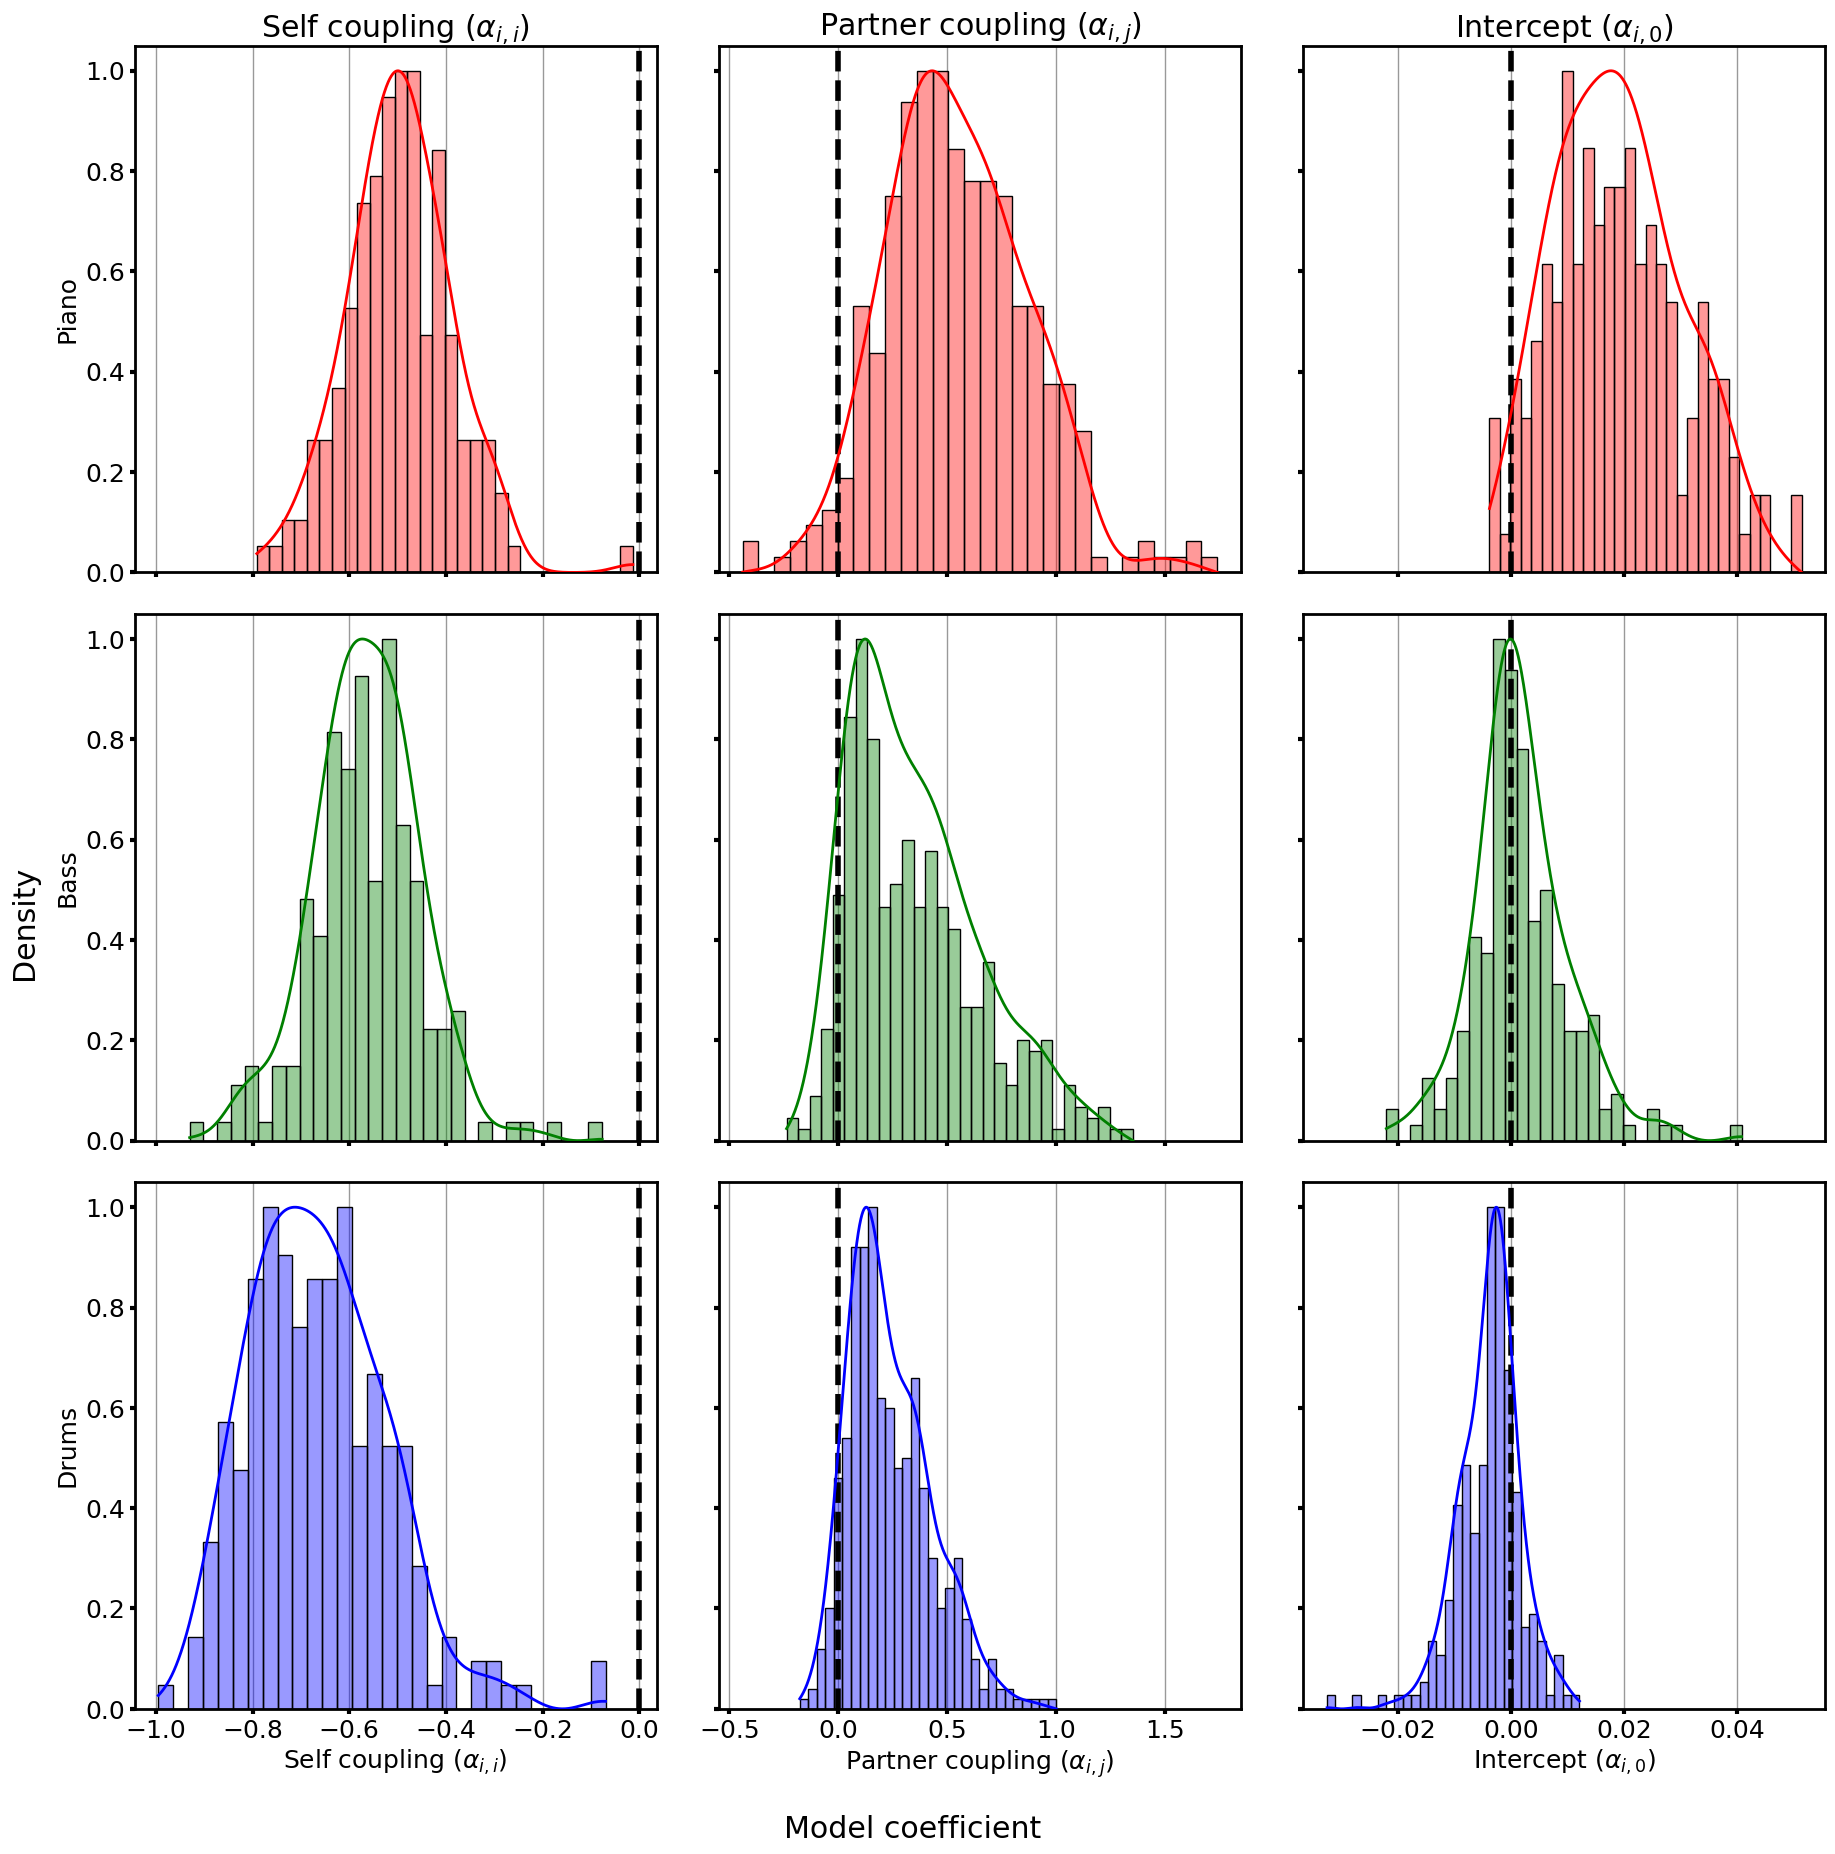

In [58]:
HistPlotCouplingTerms(clean).create_plot()
plt.show()

## Create triangle plot of mean coupling coefficients

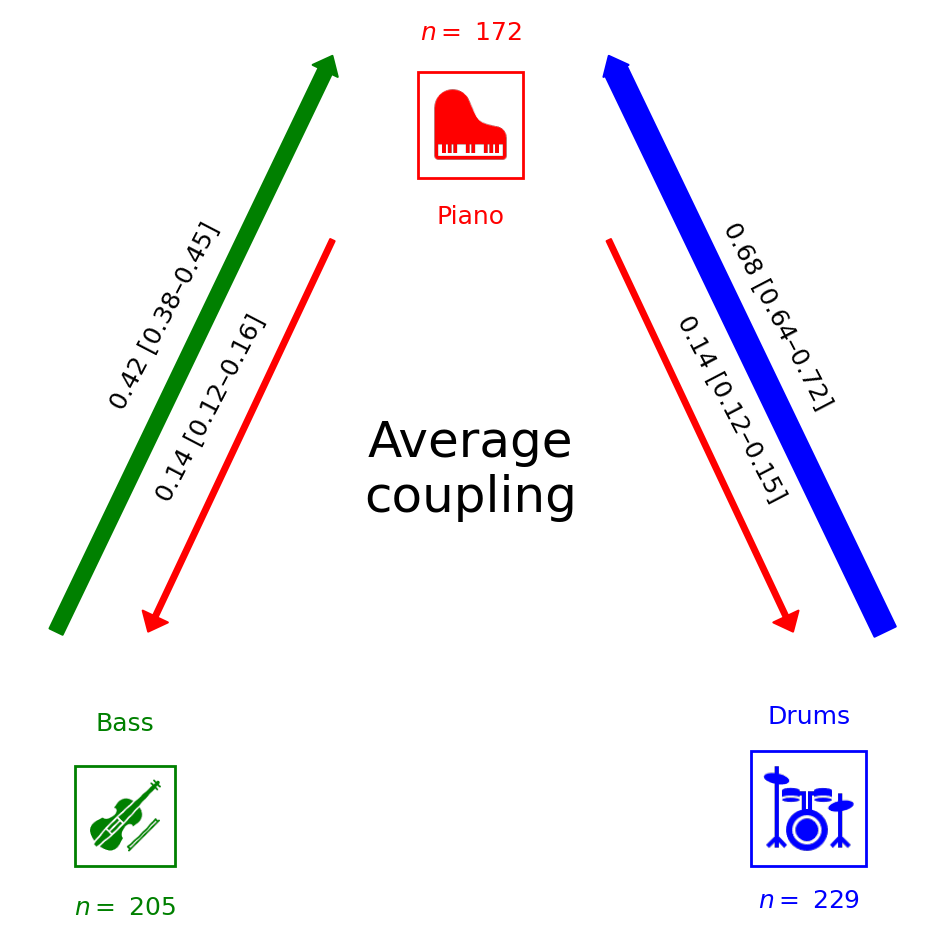

In [5]:
class TriangleWrapper(vutils.BasePlot):
    def __init__(self, model_df, **kwargs):
        self.corpus_title = kwargs.get('corpus_title', 'corpus_chronology')
        super().__init__(figure_title=fr'coordination_plots\triangleplot_alltrios_{self.corpus_title}', **kwargs)
        self.df = model_df.copy(deep=True)
        self.df.loc['pianist', :] = ''
        self.df['performer'] = ''
        self.fig, self.ax = plt.subplots(nrows=1, ncols=1, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 2))

    def _create_plot(self):
        TriangleAxis(self.df, self.ax, text_override='Average\ncoupling').create_plot()

    def _format_fig(self):
        self.fig.subplots_adjust(top=0.99, bottom=0.01, left=0.01, right=0.99)

TriangleWrapper(clean).create_plot()
plt.show()

## Create triangle plot for all individual trios

Ahmad Jamal
Bill Evans
Bud Powell
John Hicks
Junior Mance
Keith Jarrett
Kenny Barron
McCoy Tyner
Oscar Peterson
Tommy Flanagan


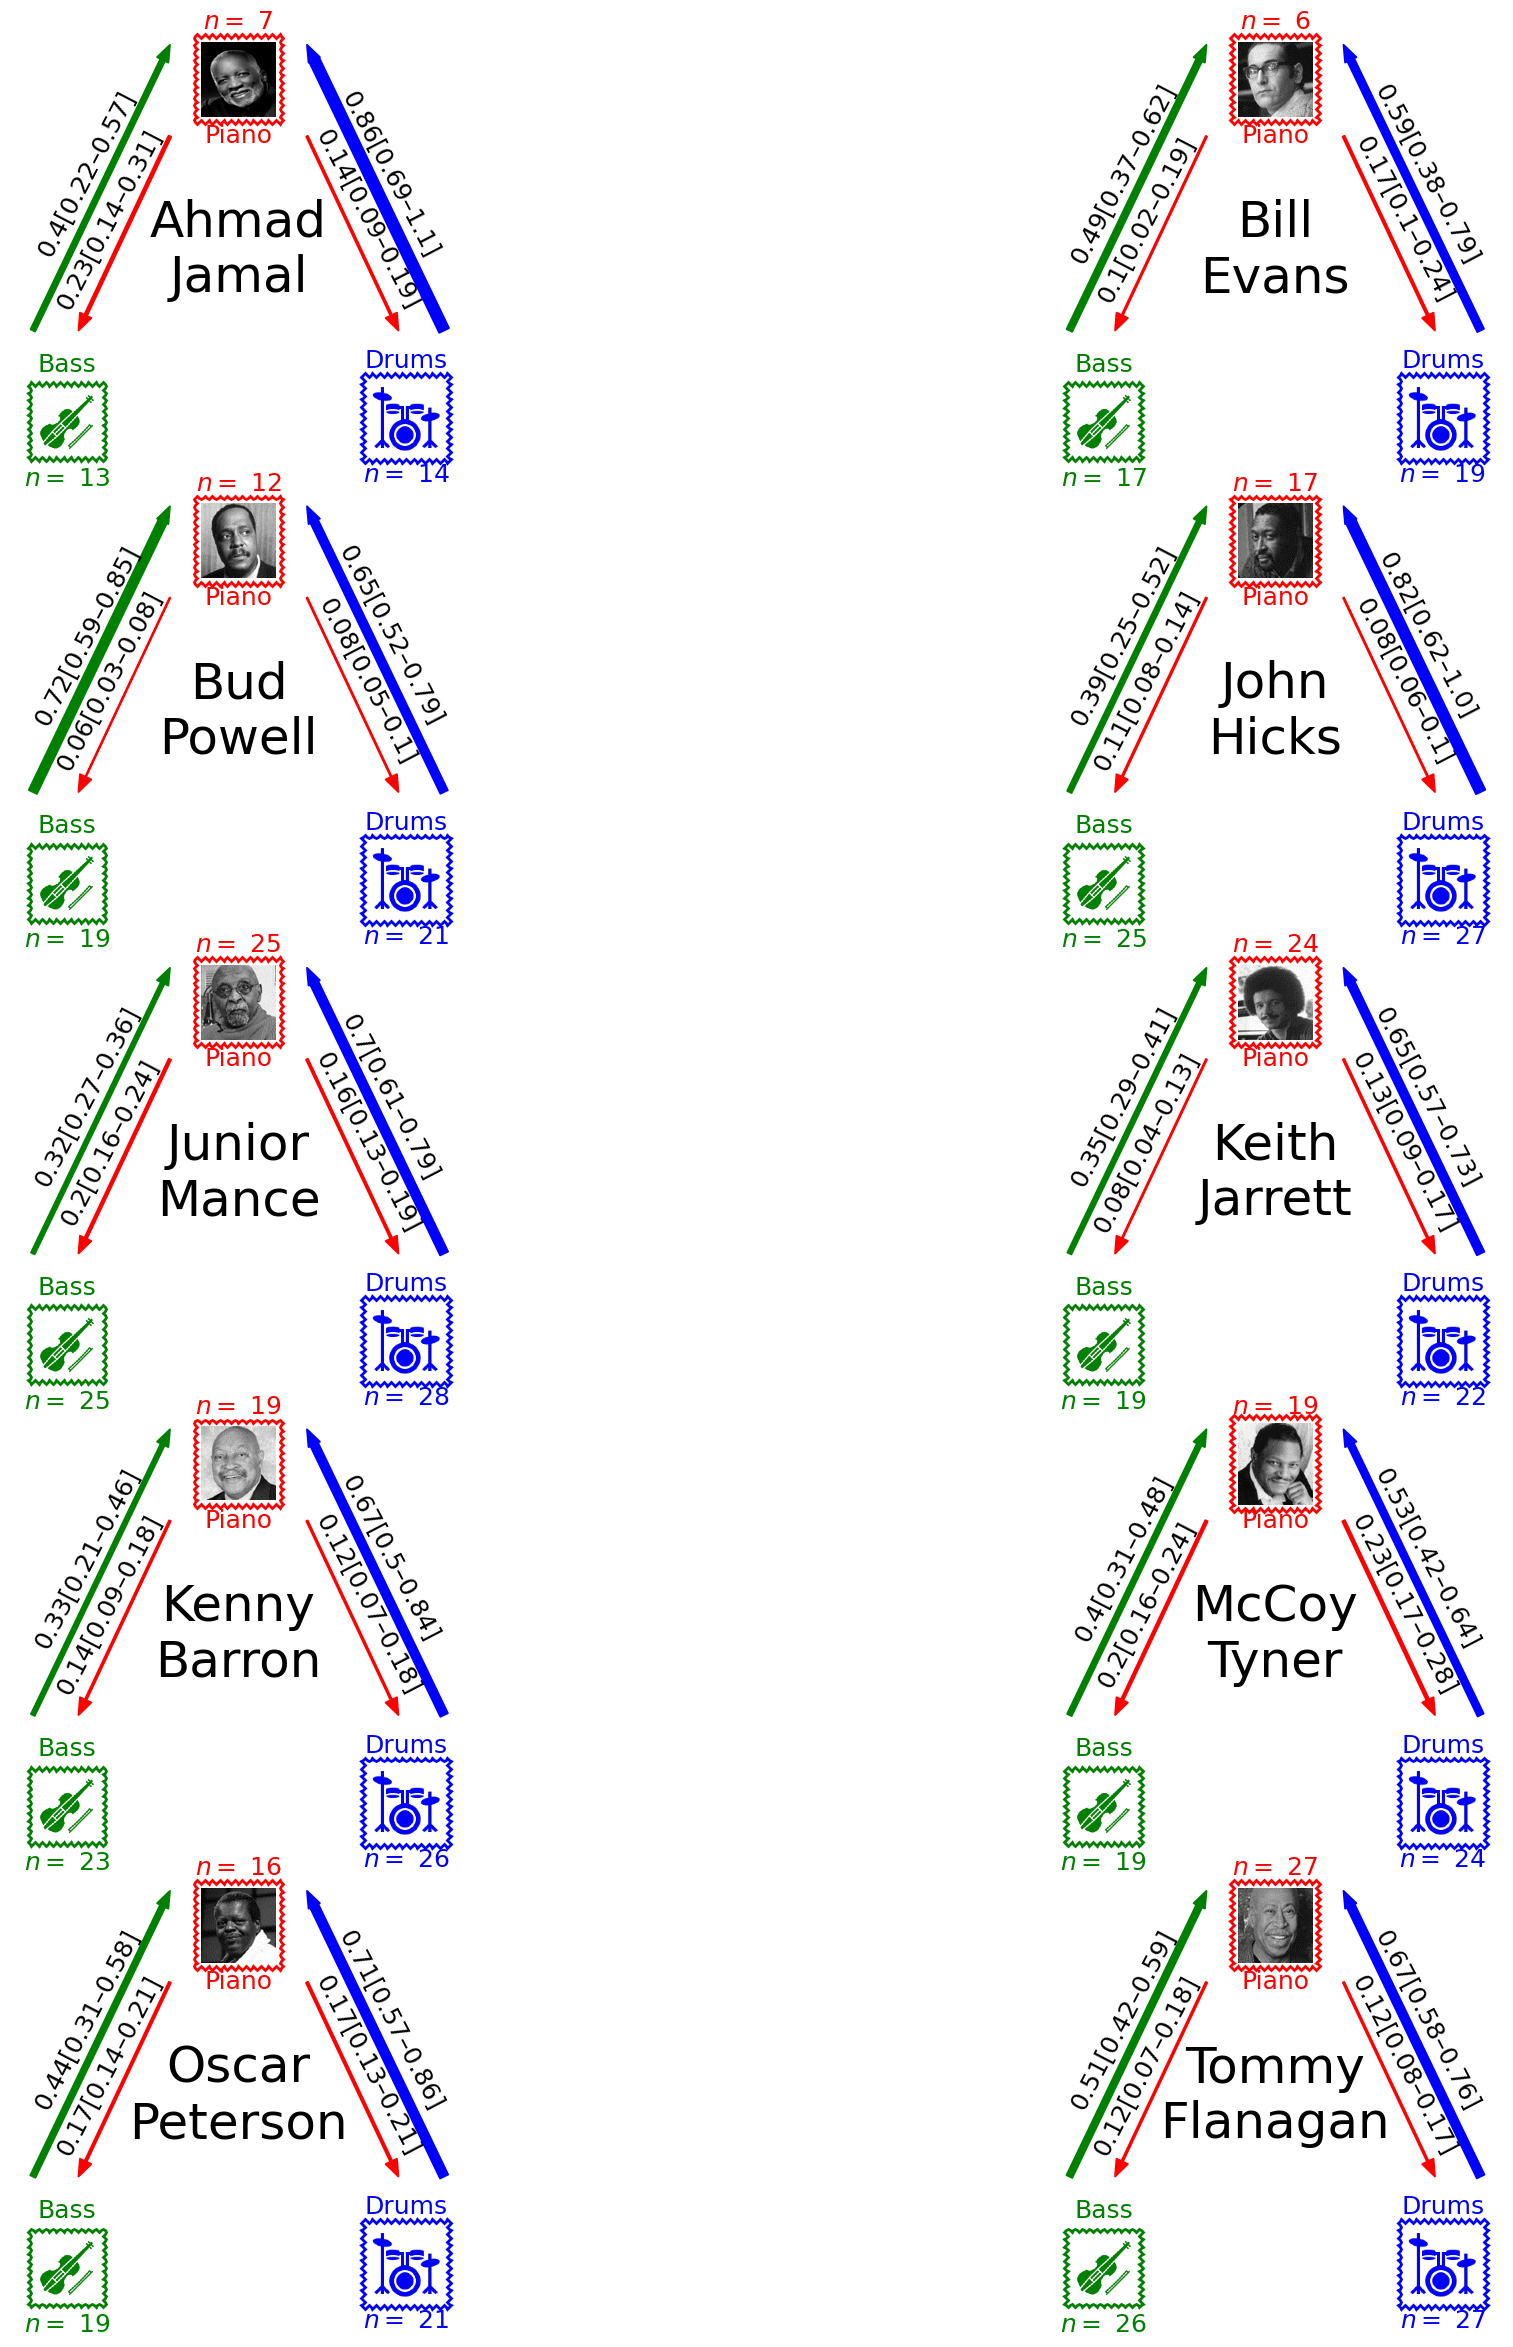

In [9]:
class TrianglePlotTrioWrapper(vutils.BasePlot):
    """Creates a triangle plot for each trio combination in the chronology corpus"""
    TRIANGLE_KWS = dict(
        starting_zoom=0.75, arrow_mod=9, head_width=9, len_mod=0.9,
        performer_picture_zoom=1.1, text_mod=0.125
    )

    def __init__(self, trio_df: pd.DataFrame, **kwargs):
        self.corpus_title = kwargs.get('corpus_title', 'corpus')
        super().__init__(figure_title=fr'coordination_plots\triangleplot_trios_{self.corpus_title}', **kwargs)
        self.nobs_cutoff = kwargs.get('nobs_cutoff', 30)
        self.df = trio_df
        self.df.loc[self.df['instrument'] == 'piano', 'performer'] = self.df['pianist']
        self.df.loc[self.df['instrument'] != 'piano', 'performer'] = ""
        self.fig, self.ax = plt.subplots(nrows=5, ncols=2, figsize=(vutils.WIDTH, vutils.WIDTH * 5/4))

    def _create_plot(self):
        for a, (idx, grp) in zip(self.ax.flatten(), self.df.groupby('pianist')):
            print(idx)
            TriangleAxis(grp, a, **self.TRIANGLE_KWS).create_plot()

    def _format_fig(self):
        """Format figure-level parameters"""
        self.fig.subplots_adjust(left=-0.1, right=1.1, top=0.99, bottom=0.01, hspace=0.01, wspace=-0.15)


TrianglePlotTrioWrapper(clean).create_plot()
plt.show()

## Create bar plot of coupling coefficients

C:\Python Projects\jazz-corpus-analysis\src\visualise\coordination_plots.py:543: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  marker_df = self.df.groupby('variable').mean().reset_index(drop=False)


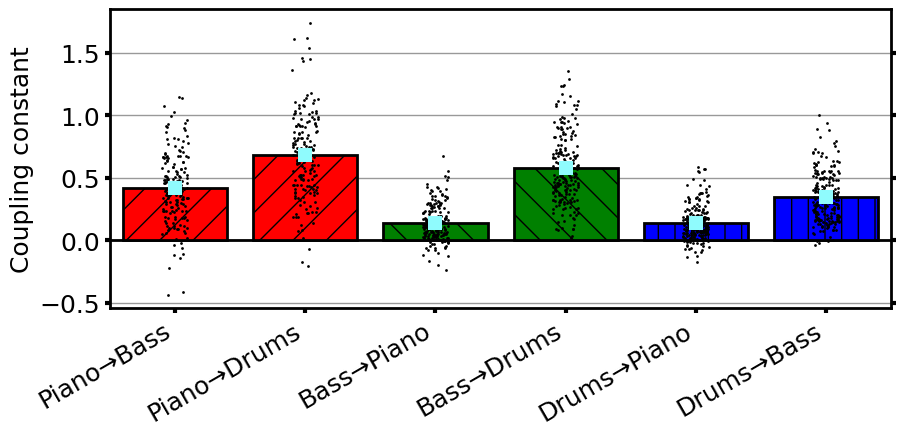

In [12]:
BarPlotCouplingCoefficients(clean).create_plot()
plt.show()

## Control analyses

### Compare coupling across 1st/2nd half of a track

In [13]:
partial_models = []
# Iterate over every track
for track in onsets:
    summary_dict = pd.DataFrame(track.summary_dict)
    # Get the duration of the track
    duration = np.ceil(summary_dict['beats'].max())
    # Get the timestamps for the start and end of the first and second half
    first_half_range = 0, np.ceil(duration / 2)
    second_half_range = first_half_range[1], duration
    # Get the data for the first and second half using hte timestamps
    first_half = summary_dict[(first_half_range[0] <= summary_dict['beats']) & (summary_dict['beats'] <= first_half_range[1])]
    second_half = summary_dict[(second_half_range[0] <= summary_dict['beats']) & (summary_dict['beats'] <= second_half_range[1])]
    # Iterate over each half separately
    for data, half in zip([first_half, second_half], [1, 2]):
        # Create the model for each instrument from the data for each half
        for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
            mine = data[instr]
            theirs = data[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != instr]]
            partial_model = PhaseCorrection(my_beats=mine, their_beats=theirs)
            # Append the model results, plus some additional metadata
            partial_models.append(track.item | partial_model.summary_dict | dict(instrument=instr, half=half))
partial_df = pd.DataFrame(partial_models)

KeyboardInterrupt: 

In [ ]:
# Get the minimum number of observations for a half, per instrument and track
small = (partial_df.groupby(['mbz_id', 'instrument'])['nobs'].min() >= 30).reset_index(drop=False)
checker = {}
# Iterate through the rows of the dataframe of acceptable/non-acceptable tracks
for idx, row in small[small['nobs']][['mbz_id', 'instrument']].iterrows():
    # If this row and instrument is acceptable, add the mbz_id as a dictionary key and the instrument to a list (value)
    if row['mbz_id'] not in checker.keys():
        checker[row['mbz_id']] = [row['instrument']]
    else:
        checker[row['mbz_id']].append(row['instrument'])

In [ ]:
# Get the acceptable rows in the full dataframe based on our dictionary of lists
is_ok = [row for _, row in partial_df.iterrows() if row['mbz_id'] in checker.keys() and row['instrument'] in checker[row['mbz_id']]]

In [ ]:
# Combine the acceptable rows into one dataframe and pivot to get coupling responses as their own column
melt = (
    pd.DataFrame(is_ok)
    .melt(id_vars=['mbz_id', 'half'], value_vars=['coupling_piano', 'coupling_drums', 'coupling_bass', 'half'])
    .dropna()
    .pivot_table(values='value', index=['mbz_id', 'variable'], columns='half')
    .reset_index(drop=False)
    .rename(columns={1: 'half_1', 2: 'half_2'})
)
melt['variable'] = melt['variable'].str.replace('coupling_', '')

In [ ]:
RegPlotCouplingHalves(melt).create_plot()
plt.show()

### Compare coupling, granger causality, and cross-correlation

In [ ]:
RegPlotCouplingGrangerCross(clean).create_plot()
plt.show()

### Compare higher-order models

In [67]:
models = []
# Iterate over every track
for track in onsets:
    summary_dict = pd.DataFrame(track.summary_dict)
    # Iterate over every instrument
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        # Subset to get my onsets and partner onsets as separate dataframes
        mine = summary_dict[instr]
        theirs = summary_dict[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != instr]]
        # Iterate through the desired range of model orders (up to k = 4)
        for order in range(1, 5):
            # Create models - phase correction
            model = PhaseCorrection(my_beats=mine, their_beats=theirs, order=order)
            # Append summary results for creating a dataframe
            models.append(dict(
                instr=instr, id=track.item['mbz_id'], nobs=model.summary_dict['nobs'],
                r2=model.summary_dict['rsquared_adj'], bic=model.summary_dict['bic'],
                order=order,
            ))
# Create the dataframe
high_df = pd.DataFrame(models)

In [68]:
# Get the number of missing values per track-instrument combination
high_df['nan_count'] = high_df.groupby(['id', 'instr'])['r2'].transform(lambda x: x.isnull().sum())
high_df['nobs_count'] = high_df.groupby(['id', 'instr'])['nobs'].transform(lambda x: x.min())
# Remove tracks with more than 1 missing value and not enough observations
high_df_clean = high_df[(high_df['nan_count'] < 1) & (high_df['nobs_count'] > 30)].reset_index(drop=True)

,instr,id,nobs,r2,bic,order,nan_count,nobs_count
152,drums,69b7b595-3646-4543-9d7b-220b7580365e,203.0,0.767767,-949.942750,1,0,35.0
153,drums,69b7b595-3646-4543-9d7b-220b7580365e,117.0,0.791152,-550.462769,2,0,35.0
154,drums,69b7b595-3646-4543-9d7b-220b7580365e,68.0,0.770663,-309.181589,3,0,35.0
155,drums,69b7b595-3646-4543-9d7b-220b7580365e,35.0,0.789209,-156.602311,4,0,35.0
472,bass,ac107146-4557-438d-ac7a-e746a6b59d2d,104.0,0.511541,-412.851049,1,0,33.0
473,bass,ac107146-4557-438d-ac7a-e746a6b59d2d,62.0,0.437227,-222.695878,2,0,33.0
474,bass,ac107146-4557-438d-ac7a-e746a6b59d2d,44.0,0.295957,-139.939327,3,0,33.0
475,bass,ac107146-4557-438d-ac7a-e746a6b59d2d,33.0,0.663302,-145.680579,4,0,33.0
476,drums,ac107146-4557-438d-ac7a-e746a6b59d2d,126.0,0.542326,-663.427364,1,0,37.0
477,drums,ac107146-4557-438d-ac7a-e746a6b59d2d,75.0,0.516279,-373.043175,2,0,37.0


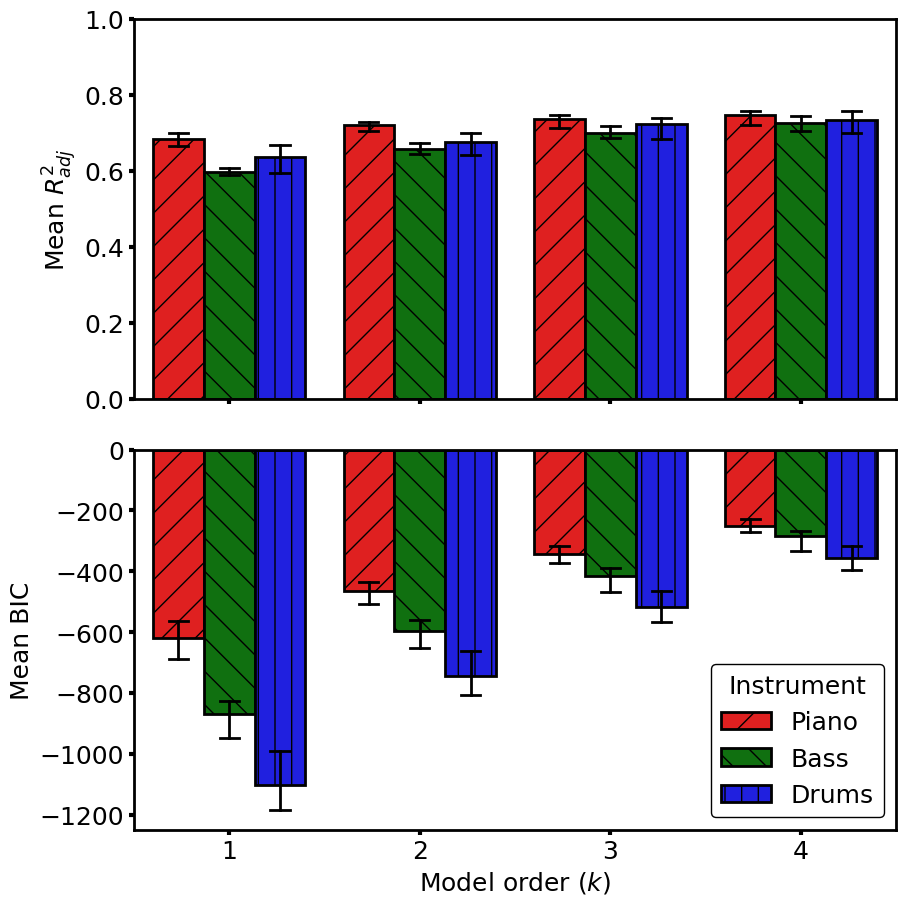

In [84]:
import seaborn as sns

class BarPlotModelComparison(vutils.BasePlot):
    BAR_KWS = dict(
        errorbar=('ci', 95), estimator=np.nanmean, errwidth=2,
        errcolor=vutils.BLACK, edgecolor=vutils.BLACK, lw=2,
        n_boot=10, seed=1, capsize=0.1, width=0.8,
        palette=vutils.RGB, hue_order=utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()
    )

    def __init__(self, model_df, **kwargs):
        self.corpus_title = kwargs.get('corpus_title', 'corpus_chronology')
        super().__init__(figure_title=fr'coordination_plots\barplot_modelcomparison_{self.corpus_title}', **kwargs)
        self.df = (
            model_df.set_index('instr')
            .loc[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
            .reset_index(drop=False)
        )
        self.fig, self.ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(vutils.WIDTH / 2, vutils.WIDTH / 2))
        self.hand, self.lab = None, None

    def _create_plot(self):
        for ax, var in zip(self.ax.flatten(), ['r2', 'bic']):
            sns.barplot(data=self.df, x='order', y=var, hue='instr', ax=ax, **self.BAR_KWS)

    def _format_ax(self):
        repeater = lambda x: [val for val in x for _ in range(0, 4)]
        for ax in self.ax.flatten():
            self.hand, self.lab = ax.get_legend_handles_labels()
            ax.get_legend().remove()
            plt.setp(ax.spines.values(), linewidth=2)
            ax.tick_params(axis='both', width=3)
            for patch, hatch in zip(ax.patches, repeater(vutils.HATCHES[:3])):
                patch.set_hatch(hatch)
        self.ax[0].set(ylabel=r'Mean $R^{2}_{adj}$', xlabel='', ylim=(0, 1))
        self.ax[1].set(ylabel='Mean BIC', ylim=(-1250, 0), xlabel='Model order ($k$)')

    def _format_fig(self):
        self.ax[1].legend(
            self.hand, ['Piano', 'Bass', 'Drums'],
            loc='lower right', title='Instrument', frameon=True,
            framealpha=1, edgecolor=vutils.BLACK
        )
        self.fig.tight_layout()

BarPlotModelComparison(high_df_clean).create_plot()
plt.show()

## Simulations: individual strategies

### Get parameters for simulations

In [85]:
cols = ['self_coupling', 'coupling_piano', 'coupling_bass', 'coupling_drums', 'resid_std', 'intercept']
params = (
    clean.groupby('instrument')
    [cols]
    .mean()
    .to_dict(orient='index')
)

In [86]:
# Get mean parameters from our original parameters
mean_coupling = np.nanmean(clean[['coupling_piano', 'coupling_drums', 'coupling_bass']].values.flatten())
mean_self_coupling = np.nanmean(clean['self_coupling'].values)
mean_intercept = np.nanmean(clean['intercept'].values)
noise_constant = 0.005

In [97]:
total_coupling_strength = sum(sum(i for k, i in params[instr].items() if 'coupling_' in k and not np.isnan(i)) for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys())

### Create simulations using original coupling parameters

In [98]:
original_params = {
    'piano': {
        **params['piano'],
    },
    'bass': {
        **params['bass'],
    },
    'drums': {
        **params['drums'],
    },
}

In [99]:
original = SimulationManager(original_params, tempo=120, n_sims=500)
original.run_simulations()
original.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.8s finished


0.014088215921108932

### Create democracy simulations

In [100]:
balanced_params = {
    'piano': {
        **params['piano'],
        'coupling_bass': total_coupling_strength / 6,
        'coupling_drums': total_coupling_strength / 6,
    },
    'bass': {
        **params['bass'],
        'coupling_piano': total_coupling_strength / 6,
        'coupling_drums': total_coupling_strength / 6,
    },
    'drums': {
        **params['drums'],
        'coupling_piano': total_coupling_strength / 6,
        'coupling_bass': total_coupling_strength / 6,
    }
}

In [101]:
balanced = SimulationManager(balanced_params, tempo=120, n_sims=500)
balanced.run_simulations()
balanced.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.8s finished


0.015568555826353716

### Create anarchy simulations

In [102]:
no_coupling_params = {
    'piano': {
        **params['piano'],
        'coupling_bass': 0,
        'coupling_drums': 0,
    },
    'bass': {
        **params['bass'],
        'coupling_piano': 0,
        'coupling_drums': 0,
    },
    'drums': {
        **params['drums'],
        'coupling_piano': 0,
        'coupling_bass': 0,
    }
}

In [103]:
no_coupling = SimulationManager(no_coupling_params, tempo=120, n_sims=500)
no_coupling.run_simulations()
no_coupling.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.6s finished


18.459335953190173

### Create drummer-leader simulations

In [104]:
drums_leader_params = {
    'piano': {
        **params['piano'],
        'coupling_bass': 0,
        'coupling_drums': total_coupling_strength / 2,
    },
    'bass': {
        **params['bass'],
        'coupling_piano': 0,
        'coupling_drums': total_coupling_strength / 2,
    },
    'drums': {
        **params['drums'],
        'coupling_piano': 0,
        'coupling_bass': 0,
    }
}

In [105]:
drums_leader = SimulationManager(drums_leader_params, tempo=120, n_sims=500)
drums_leader.run_simulations()
drums_leader.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.5s finished


0.014628064384321432

### Create bass leader simulations

In [106]:
bass_leader_params = {
    'piano': {
        **params['piano'],
        'coupling_bass': total_coupling_strength / 2,
        'coupling_drums': 0,
    },
    'bass': {
        **params['bass'],
        'coupling_piano': 0,
        'coupling_drums': 0,
    },
    'drums': {
        **params['drums'],
        'coupling_piano': 0,
        'coupling_bass': total_coupling_strength / 2,
    }
}

In [107]:
bass_leader = SimulationManager(bass_leader_params, tempo=120, n_sims=500)
bass_leader.run_simulations()
bass_leader.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.5s finished


0.015240045075225363

### Create piano leader simulations

In [108]:
piano_leader_params = {
    'piano': {
        **params['piano'],
        'coupling_bass': 0,
        'coupling_drums': 0,
    },
    'bass': {
        **params['bass'],
        'coupling_piano': total_coupling_strength / 2,
        'coupling_drums': 0,
    },
    'drums': {
        **params['drums'],
        'coupling_piano': total_coupling_strength / 2,
        'coupling_bass': 0,
    }
}

In [109]:
piano_leader = SimulationManager(piano_leader_params, tempo=120, n_sims=500)
piano_leader.run_simulations()
piano_leader.get_mean_rms()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.0s finished


0.016320848225413048

### Plot proportional RMS

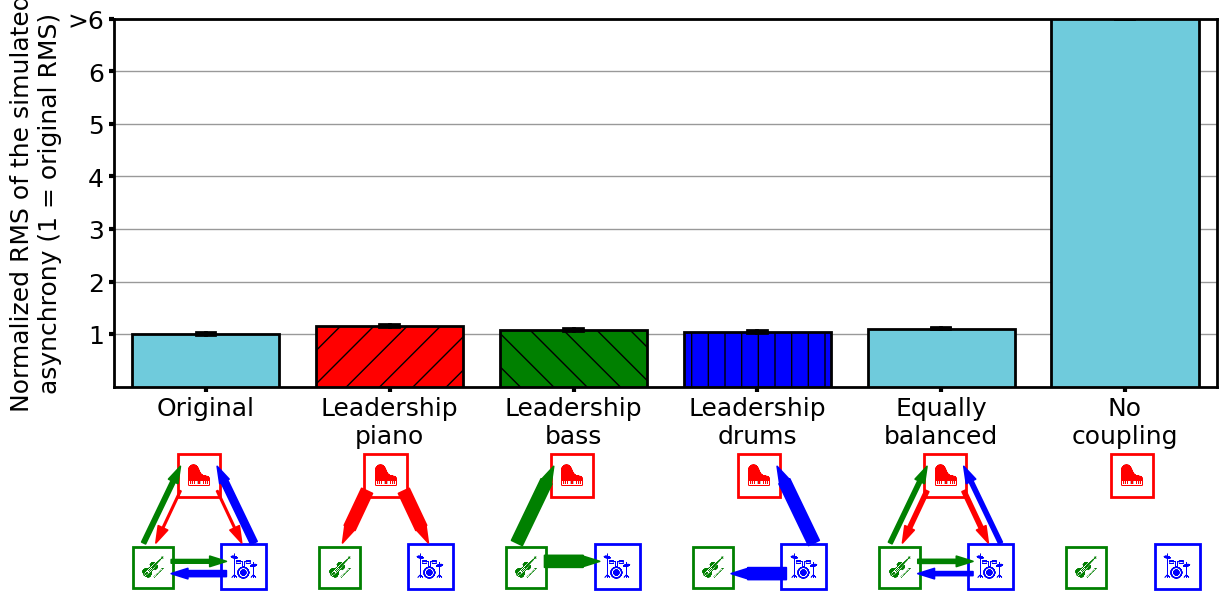

In [110]:
BarPlotSimulationComparison(
    all_sims=[original, piano_leader, bass_leader, drums_leader, balanced, no_coupling],
    all_params=[params, piano_leader_params, bass_leader_params, drums_leader_params, balanced_params, no_coupling_params]
).create_plot()